In [2]:
from datetime import datetime

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 20)

In [114]:
df = pd.read_csv("full_train_with_outlier_prob.csv", index_col=0).reset_index(drop=True)
df["Date"] = df["Date"].apply(lambda x: datetime.fromisoformat(x))
df["Year"] = df["Date"].apply(lambda x: x.year)
df["FTR"] = df["FTR"].map({"A": -1, "D": 0, "H": 1})

In [115]:
teams_df = pd.concat([
    df.rename(
        {"HomeTeam": "Team", "HS": "Shots", "HST": "ShotsOnTarget", "HC": "Corners", "HF": "Fouls", "HY": "YellowCards", "HR": "RedCards"}
        ,axis=1)[["Date", "Team", "FTHG", "FTAG", "HTHG", "HTAG", "Shots", "ShotsOnTarget", "Corners", "Fouls", "YellowCards", "RedCards"]],
    df.rename(
        {"AwayTeam": "Team", "FTAG": "FTHG", "HTAG": "HTHG", "FTHG": "FTAG", "HTHG": "HTAG", "AS": "Shots", "AST": "ShotsOnTarget", "AC": "Corners", "AF": "Fouls", "AY": "YellowCards", "AR": "RedCards"}
        ,axis=1)[["Date", "Team", "FTHG", "FTAG", "HTHG", "HTAG", "Shots", "ShotsOnTarget", "Corners", "Fouls", "YellowCards", "RedCards"]]
])

def calculate_win(home_goals, away_goals):
    results = []
    for home, away in zip(home_goals, away_goals):
        if home < away:
            results.append("A")
        elif home > away:
            results.append("H")
        else:
            results.append("D")
    return results

teams_df["Year"] = teams_df["Date"].apply(lambda x: x.year)
teams_df["HTR"] = calculate_win(teams_df["HTHG"], teams_df["HTAG"])
teams_df["HTR"] = teams_df["HTR"].map({"A": -1, "D": 0, "H": 1})
teams_df["FTR"] = calculate_win(teams_df["FTHG"], teams_df["FTAG"])
teams_df["FTR"] = teams_df["FTR"].map({"A": -1, "D": 0, "H": 1})

In [116]:
teams_in_2022 = teams_df.loc[teams_df["Year"]==2022]["Team"].unique()
teams_df = teams_df.loc[teams_df["Team"].apply(lambda x: x in teams_in_2022)].copy()
teams_success_by_year = teams_df.groupby(["Team", "Year"])["FTR"].mean().to_dict()

In [117]:
# Historical performance

In [332]:
hp_df = teams_df.groupby(["Team", "Year"])[["FTR", "FTHG", "FTAG"]].aggregate(np.mean).reset_index().copy()
hp_df.head()

C:\Users\vojte\AppData\Local\Temp\ipykernel_17816\1669338373.py:1: FutureWarning: The provided callable <function mean at 0x0000017CF17C0C20> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  hp_df = teams_df.groupby(["Team", "Year"])[["FTR", "FTHG", "FTAG"]].aggregate(np.mean).reset_index().copy()


,Team,Year,FTR,FTHG,FTAG
0,AEK,2005,0.714286,1.500000,0.500000
1,AEK,2006,0.483871,1.677419,0.677419
2,AEK,2007,0.428571,2.000000,0.892857
3,AEK,2008,0.387097,1.774194,0.870968
4,AEK,2009,0.250000,1.357143,0.892857


<Axes: xlabel='Year', ylabel='FTR'>

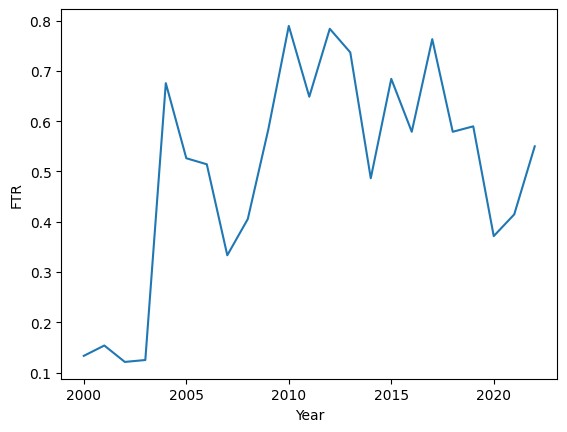

In [119]:
sns.lineplot(
    x=hp_df.loc[hp_df["Team"]=="Barcelona"]["Year"],
    y=hp_df.loc[hp_df["Team"]=="Barcelona"]["FTR"]
    )

In [144]:
# Head to head

In [462]:
temp_df = df[["Date", "HomeTeam", "AwayTeam", "FTHG", "FTAG", "AvgH", "AvgD", "AvgA"]].copy()
for i in range(len(temp_df)):
    if temp_df.at[i, "HomeTeam"] > temp_df.at[i, "AwayTeam"]:
        temp_df.at[i, "HomeTeam"], temp_df.at[i, "AwayTeam"] = temp_df.at[i, "AwayTeam"], temp_df.at[i, "HomeTeam"]
        temp_df.at[i, "FTHG"], temp_df.at[i, "FTAG"] = temp_df.at[i, "FTAG"], temp_df.at[i, "FTHG"]
        temp_df.at[i, "AvgH"], temp_df.at[i, "AvgA"] = temp_df.at[i, "AvgA"], temp_df.at[i, "AvgH"]

temp_df.head()

,Date,HomeTeam,AwayTeam,FTHG,FTAG,AvgH,AvgD,AvgA
0,2021-09-24,Bayern Munich,Greuther Furth,3.0,1.0,1.088333,11.971667,21.578333
1,2016-09-10,Osasuna,Real Madrid,2.0,5.0,33.500000,14.571429,1.060000
2,2017-04-26,Barcelona,Osasuna,7.0,1.0,1.038571,18.434286,41.225714
3,2017-11-29,Paris SG,Troyes,2.0,0.0,1.043333,16.083333,43.000000
4,2016-10-29,Barcelona,Granada,1.0,0.0,1.051429,16.857143,38.571429


In [463]:
temp_df["FTR"] = calculate_win(temp_df["FTHG"], temp_df["FTAG"])
temp_df["FTR"] = temp_df["FTR"].map({"H": 1, "D": 0, "A": -1})
temp_df["Year"] = temp_df["Date"].apply(lambda x: x.year)
team_matchups = temp_df.groupby(["HomeTeam", "AwayTeam", "Year"])[["FTHG", "FTAG", "FTR"]].aggregate(np.mean).sort_values(by=["HomeTeam", "AwayTeam", "Year"]).reset_index().copy()

C:\Users\vojte\AppData\Local\Temp\ipykernel_17816\154257140.py:4: FutureWarning: The provided callable <function mean at 0x0000017CF17C0C20> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  team_matchups = temp_df.groupby(["HomeTeam", "AwayTeam", "Year"])[["FTHG", "FTAG", "FTR"]].aggregate(np.mean).sort_values(by=["HomeTeam", "AwayTeam", "Year"]).reset_index().copy()


<Axes: xlabel='Year', ylabel='FTR'>

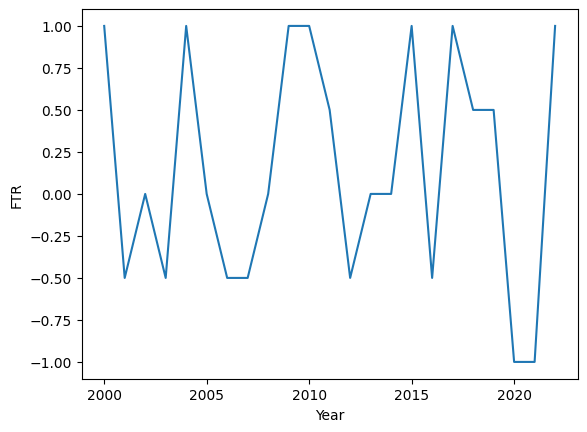

In [175]:
plot_data = team_matchups.loc[(team_matchups["HomeTeam"]=="Barcelona") & (team_matchups["AwayTeam"]=="Real Madrid")].copy()
sns.lineplot(plot_data, x="Year", y="FTR")
# sns.lineplot(plot_data, x="Date", y="FTAG")
# sns.lineplot(plot_data, x="Date", y="FTHG")

In [186]:
goals_home = temp_df.groupby(["HomeTeam", "AwayTeam", "Year"])["FTHG"].mean().to_dict()
goals_away = temp_df.groupby(["HomeTeam", "AwayTeam", "Year"])["FTAG"].mean().to_dict()
full_time_results = goals_home = temp_df.groupby(["HomeTeam", "AwayTeam", "Year"])["FTR"].mean().to_dict()

In [190]:
temp_df

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,Year
0,2021-09-24,Bayern Munich,Greuther Furth,3.0,1.0,1,2021
1,2016-09-10,Osasuna,Real Madrid,2.0,5.0,-1,2016
2,2017-04-26,Barcelona,Osasuna,7.0,1.0,1,2017
3,2017-11-29,Paris SG,Troyes,2.0,0.0,1,2017
4,2016-10-29,Barcelona,Granada,1.0,0.0,1,2016
...,...,...,...,...,...,...,...
152345,2000-09-10,Lleida,Murcia,0.0,0.0,0,2000
152346,2000-10-07,Creteil,Martigues,0.0,0.0,0,2000
152347,2000-08-29,Niort,Wasquehal,0.0,0.0,0,2000
152348,2000-09-06,Gueugnon,Le Mans,0.0,0.0,0,2000


In [192]:
team_matchups

{('A. Sebatspor', 'Adanaspor', 2003): 2.0,
 ('A. Sebatspor', 'Adanaspor', 2004): 4.0,
 ('A. Sebatspor', 'Ankaragucu', 2003): 1.0,
 ('A. Sebatspor', 'Ankaragucu', 2004): 2.0,
 ('A. Sebatspor', 'Ankaragucu', 2005): 0.0,
 ('A. Sebatspor', 'Ankaraspor', 2004): 1.0,
 ('A. Sebatspor', 'Ankaraspor', 2005): 1.0,
 ('A. Sebatspor', 'Besiktas', 2004): 1.5,
 ('A. Sebatspor', 'Besiktas', 2005): 2.0,
 ('A. Sebatspor', 'Bursaspor', 2003): 1.0,
 ('A. Sebatspor', 'Bursaspor', 2004): 0.0,
 ('A. Sebatspor', 'Denizlispor', 2003): 0.0,
 ('A. Sebatspor', 'Denizlispor', 2004): 2.0,
 ('A. Sebatspor', 'Denizlispor', 2005): 2.0,
 ('A. Sebatspor', 'Diyarbakirspor', 2003): 0.0,
 ('A. Sebatspor', 'Diyarbakirspor', 2004): 0.0,
 ('A. Sebatspor', 'Diyarbakirspor', 2005): 0.0,
 ('A. Sebatspor', 'Elazigspor', 2003): 3.0,
 ('A. Sebatspor', 'Elazigspor', 2004): 1.0,
 ('A. Sebatspor', 'Fenerbahce', 2003): 1.0,
 ('A. Sebatspor', 'Fenerbahce', 2004): 2.0,
 ('A. Sebatspor', 'Fenerbahce', 2005): 0.0,
 ('A. Sebatspor', 'Galata

In [225]:
xvals = [-1,5,2]
yvals = [1,2,3]
sd = np.std(xvals)
np.cov(xvals, yvals)[0][1] / (sd if sd!=0 else 1)

0.6123724356957946

In [240]:
grouped = teams_df.groupby(["Team", "Year"])
summary = grouped.agg(
    FTHG=("FTHG", "mean"),
    count=("Date", "count")
).reset_index()
summary

,Team,Year,FTHG,count
0,AEK,2005,1.500000,14
1,AEK,2006,1.677419,31
2,AEK,2007,2.000000,28
3,AEK,2008,1.774194,31
4,AEK,2009,1.357143,28
...,...,...,...,...
6991,Zwolle,2018,1.000000,33
6992,Zwolle,2019,1.444444,36
6993,Zwolle,2020,1.272727,22
6994,Zwolle,2021,0.973684,38


<Axes: xlabel='count', ylabel='FTHG'>

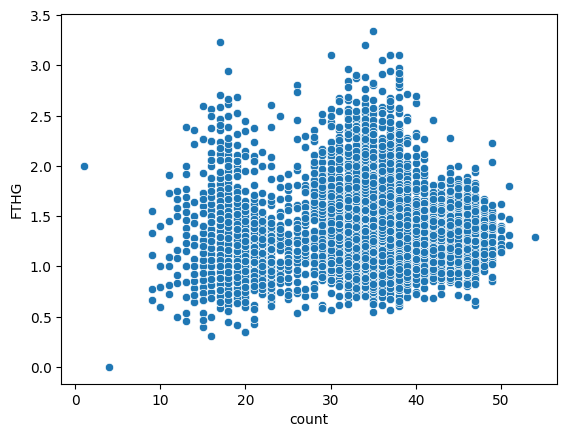

In [241]:
plot_data = summary.loc[summary["Year"]==2022]
sns.scatterplot(
    x=summary["count"],
    y=summary["FTHG"]
)

In [464]:
temp = teams_df.groupby(["Team", "Year"])["FTR"].mean().to_dict()

In [465]:
home_team_expected_ftr = []
away_team_expected_ftr = []
for i in range(temp_df.shape[0]):
    home_team_expected_ftr.append(temp.get((temp_df.at[i, "HomeTeam"], temp_df.at[i, "Year"]-1), None))
    away_team_expected_ftr.append(temp.get((temp_df.at[i, "AwayTeam"], temp_df.at[i, "Year"]-1), None))

temp_df["HT_last"] = home_team_expected_ftr
temp_df["AT_last"] = away_team_expected_ftr

In [466]:
temp = temp_df.groupby(["HomeTeam", "AwayTeam", "Year"])["FTR"].mean()

In [467]:
expected_outcome = []
for i in range(temp_df.shape[0]):
    expected_outcome.append(temp.get((temp_df.at[i, "HomeTeam"], temp_df.at[i, "AwayTeam"], temp_df.at[i, "Year"]-1), None))

temp_df["expected_outcome"] = expected_outcome

<Axes: xlabel='AT_EFTR', ylabel='expected_outcome'>

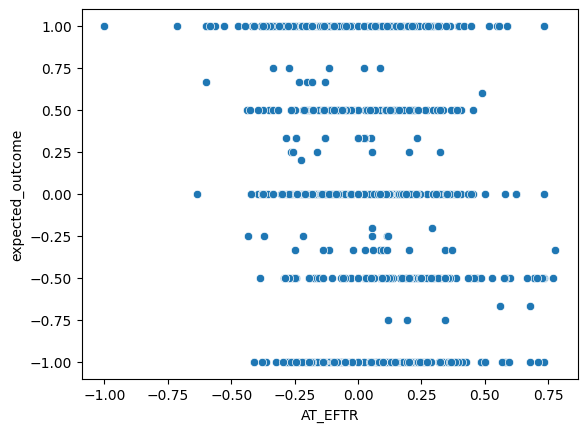

In [306]:
sns.scatterplot(data=temp_df.dropna().sample(1000), x="AT_EFTR", y="expected_outcome")

In [470]:
from sklearn.linear_model import LinearRegression

X = temp_df.dropna()[["HT_last", "AT_last", "expected_outcome"]]
y = X.pop("expected_outcome")

reg = LinearRegression()
reg.fit(X, y)

LinearRegression()

In [471]:
temp_df = temp_df.dropna(subset=["HT_last", "AT_last"]).reset_index(drop=True).copy()
temp_df["predicted_outcome"] = reg.predict(temp_df[["HT_last", "AT_last"]])

In [353]:
# temp = teams_df.groupby(["Team", "Year"])["FTR"].mean().to_dict()

# home_team_last_year = []
# away_team_last_year = []
# for i in range(temp_df.shape[0]):
#     try:
#         home_team_last_year.append(temp.get((temp_df.at[i, "HomeTeam"], temp_df.at[i, "Year"]-1), None))
#         away_team_last_year.append(temp.get((temp_df.at[i, "AwayTeam"], temp_df.at[i, "Year"]-1), None))
#     except:
#         print(temp_df.at[i, "HomeTeam"], temp_df.at[i, "AwayTeam"], temp_df.at[i, "Year"]-1)

# temp_df["HT_LY"] = home_team_last_year
# temp_df["AT_LY"] = away_team_last_year

In [472]:
temp = teams_df.groupby(["Team", "Year"])["FTR"].mean().reset_index().copy()

In [473]:
curr_team = temp["Team"][0]
steps = []
vals = []
corr3 = []
corrall = []

for i in range(temp.shape[0]):
    if temp.at[i, "Team"] == curr_team:
        if len(steps)==0:
            steps.append(1)
            vals.append(temp.at[i, "FTR"])
            corr3.append(None)
            corrall.append(None)
        else:
            steps.append(steps[-1]+1)
            vals.append(temp.at[i, "FTR"])
            if len(vals)<3:
                corr3.append(None)
                corrall.append(None)
            else:
                s3 = np.std(vals[-3:])
                c3 = np.cov([1,2,3], vals[-3:])[0][1] / (s3 if s3!=0 else 1)
                corr3.append(c3)
                sa = np.std(vals)
                ca = np.cov(steps, vals)[0][1] / (sa if sa!=0 else 1)
                corrall.append(ca)
    else:
        curr_team = temp.at[i, "Team"]
        steps = [1]
        vals = [temp.at[i, "FTR"]]
        corr3.append(None)
        corrall.append(None)

In [474]:
temp["corr_last3"] = corr3
temp["corr_all"] = corrall

In [475]:
temp.groupby(["Team", "Year"])["corr_last3"].mean().to_dict()

{('AEK', 2005): nan,
 ('AEK', 2006): nan,
 ('AEK', 2007): -1.1545892987675777,
 ('AEK', 2008): -1.2206002068101023,
 ('AEK', 2009): -1.1701010933089881,
 ('AEK', 2010): -1.0606601717798212,
 ('AEK', 2011): 1.0606601717798212,
 ('AEK', 2012): -1.0043519410003543,
 ('AEK', 2013): -0.8831529969054188,
 ('AEK', 2015): 1.1821224099665306,
 ('AEK', 2016): 1.142132030611637,
 ('AEK', 2017): 1.224282267079943,
 ('AEK', 2018): 1.1783309773950872,
 ('AEK', 2019): -0.20743733163417516,
 ('AEK', 2020): -0.8374208093343064,
 ('AEK', 2021): -0.854381651445558,
 ('AEK', 2022): -1.2224815442625878,
 ('AFC Wimbledon', 2011): nan,
 ('AFC Wimbledon', 2012): nan,
 ('AFC Wimbledon', 2013): 1.0606601717798214,
 ('AFC Wimbledon', 2014): 1.0043021832871546,
 ('AFC Wimbledon', 2015): 0.02865040885462746,
 ('AFC Wimbledon', 2016): 1.1119110871333093,
 ('AFC Wimbledon', 2017): -0.5853608106911754,
 ('AFC Wimbledon', 2018): -1.1097962125231233,
 ('AFC Wimbledon', 2019): 0.7058047276014836,
 ('AFC Wimbledon', 2020

In [476]:
temp2 = temp.groupby(["Team", "Year"])["corr_last3"].mean().to_dict()

home_team_corr3 = []
away_team_corr3 = []
for i in range(temp_df.shape[0]):
    try:
        home_team_corr3.append(temp2.get((temp_df.at[i, "HomeTeam"], temp_df.at[i, "Year"]-1), None))
        away_team_corr3.append(temp2.get((temp_df.at[i, "AwayTeam"], temp_df.at[i, "Year"]-1), None))
    except:
        print(temp_df.at[i, "HomeTeam"], temp_df.at[i, "AwayTeam"], temp_df.at[i, "Year"]-1)

temp_df["HT_corr3"] = home_team_corr3
temp_df["AT_corr3"] = away_team_corr3

In [477]:
temp2 = temp.groupby(["Team", "Year"])["corr_all"].mean().to_dict()

home_team_corrall = []
away_team_corrall = []
for i in range(temp_df.shape[0]):
    try:
        home_team_corrall.append(temp2.get((temp_df.at[i, "HomeTeam"], temp_df.at[i, "Year"]-1), None))
        away_team_corrall.append(temp2.get((temp_df.at[i, "AwayTeam"], temp_df.at[i, "Year"]-1), None))
    except:
        print(temp_df.at[i, "HomeTeam"], temp_df.at[i, "AwayTeam"], temp_df.at[i, "Year"]-1)

temp_df["HT_corr_all"] = home_team_corrall
temp_df["AT_corr_all"] = away_team_corrall

In [479]:
temp_df.to_csv("important_file.csv")

In [3]:
temp_df = pd.read_csv("important_file.csv").reset_index(drop=True)

In [4]:
temp_df

,Unnamed: 0,Date,HomeTeam,AwayTeam,FTHG,FTAG,AvgH,AvgD,AvgA,FTR,Year,HT_last,AT_last,expected_outcome,predicted_outcome,HT_corr3,AT_corr3,HT_corr_all,AT_corr_all
0,0,2021-09-24,Bayern Munich,Greuther Furth,3.0,1.0,1.088333,11.971667,21.578333,1,2021,0.800000,0.103448,NaN,0.643536,0.911206,0.467749,3.796339,-3.241593
1,1,2016-09-10,Osasuna,Real Madrid,2.0,5.0,33.500000,14.571429,1.060000,-1,2016,-0.071429,0.525000,NaN,-0.558330,1.188834,-1.223384,0.005212,3.066277
2,2,2017-04-26,Barcelona,Osasuna,7.0,1.0,1.038571,18.434286,41.225714,1,2017,0.578947,-0.200000,1.0,0.723703,0.572323,-0.682353,3.850905,-0.423452
3,3,2017-11-29,Paris SG,Troyes,2.0,0.0,1.043333,16.083333,43.000000,1,2017,0.526316,-0.243243,1.0,0.715575,-0.234926,-1.187821,3.726018,-0.295292
4,4,2016-10-29,Barcelona,Granada,1.0,0.0,1.051429,16.857143,38.571429,1,2016,0.684211,-0.282051,1.0,0.898089,-0.244169,-0.960411,3.783736,-1.680301
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94203,94203,2001-03-02,Empoli,Sampdoria,0.0,0.0,2.460000,2.466667,2.966667,0,2001,0.000000,0.176471,1.0,-0.165229,NaN,NaN,NaN,NaN
94204,94204,2001-09-15,Nimes,Niort,0.0,0.0,2.500000,2.600000,2.600000,0,2001,-0.150000,0.285714,0.0,-0.406523,NaN,NaN,NaN,NaN
94205,94205,2001-09-28,Genoa,Ternana,0.0,0.0,3.450000,2.550000,2.100000,0,2001,-0.187500,0.176471,-1.0,-0.338725,NaN,NaN,NaN,NaN
94206,94206,2001-03-18,Salernitana,Ternana,0.0,0.0,2.375000,2.450000,3.075000,0,2001,-0.117647,0.176471,0.0,-0.274089,NaN,NaN,NaN,NaN


In [72]:
from sklearn.model_selection import train_test_split

X = temp_df[["FTR", "predicted_outcome", "AvgH", "AvgD", "AvgA", "HT_last", "AT_last", "HT_corr3", "AT_corr3"]].dropna().copy()
y = X.pop("FTR")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [73]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix, f1_score

reg = KNeighborsClassifier(n_neighbors=50)
reg.fit(X_train, y_train)

y_pred = reg.predict(X_test)
print(confusion_matrix(y_test, y_pred))

print(f1_score(y_test, y_pred, average="macro"))

[[3883  386 1759]
 [2065  354 1931]
 [1981  372 3818]]
0.4147580298494704
